**1) Загрузка библиотек и датасета.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import matplotlib.pyplot as plt
import os
import numpy as np

# Пути к данным
train_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
test_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
val_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'

**2) Предобработка данных:**

In [3]:
classes = os.listdir(train_path)
num_classes = len(classes)
print(f'Найдено {num_classes} классов: {classes}')

# Проверка размеров тренировочного набора данных
train_count = sum([len(files) for _, _, files in os.walk(train_path)])
test_count = sum([len(files) for _, _, files in os.walk(test_path)])
val_count = sum([len(files) for _, _, files in os.walk(val_path)])

print(f'Обучающих изображений: {train_count}')
print(f'Тестовых изображений: {test_count}')
print(f'Валидационных изображений: {val_count}')

# Создание генераторов данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


Найдено 15 классов: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']
Обучающих изображений: 15000
Тестовых изображений: 3000
Валидационных изображений: 3000
Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


**Вывод по одному примеру объекта каждого класса.**

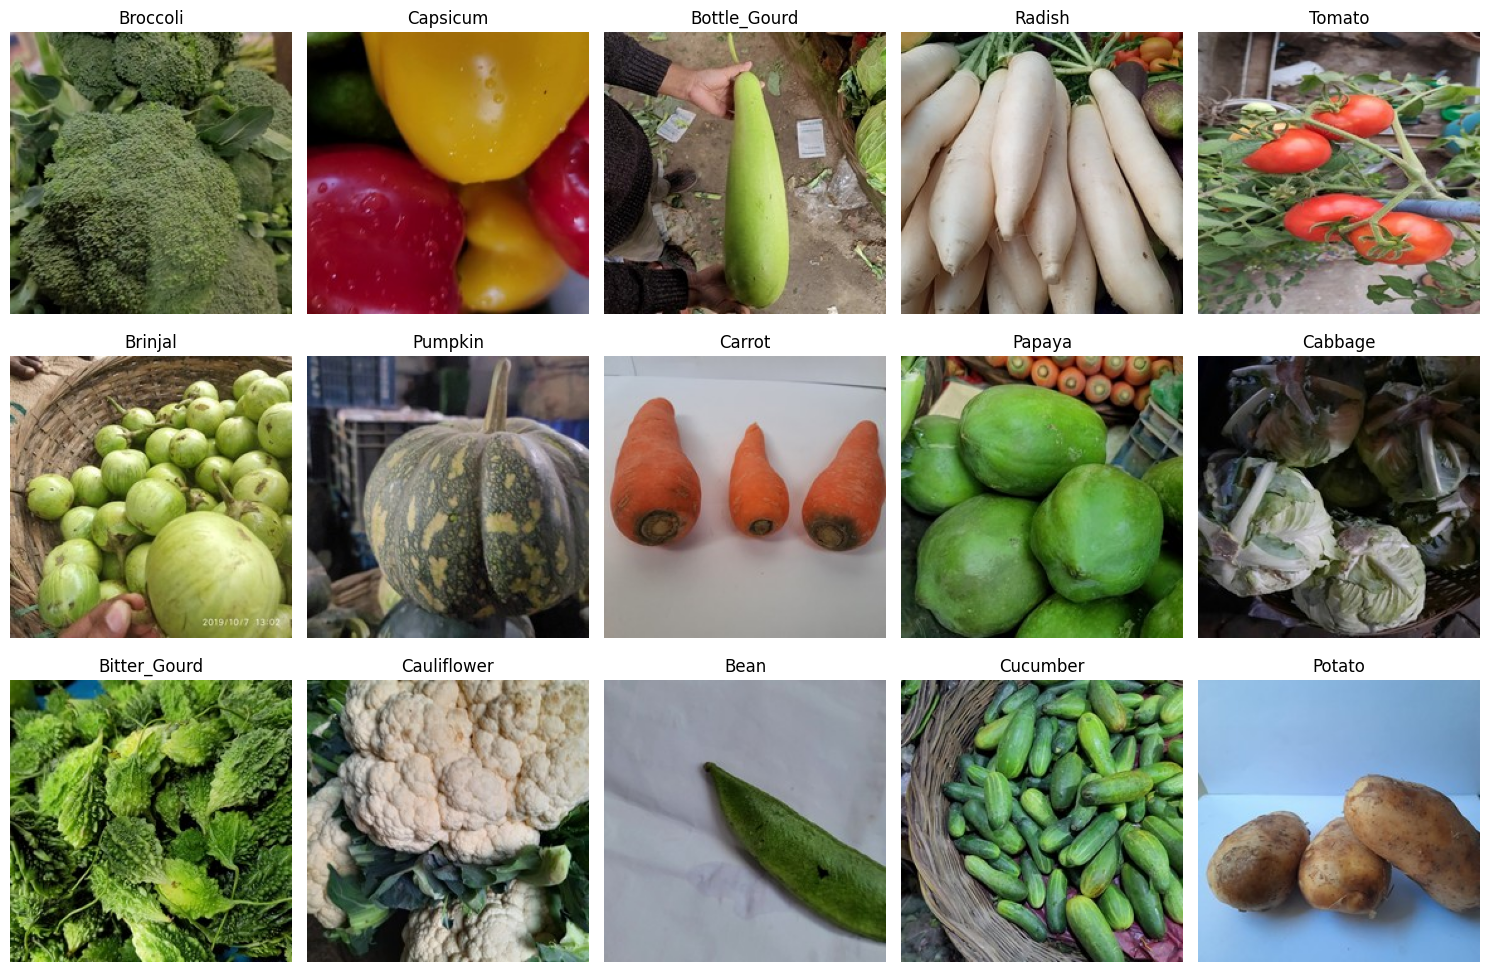

In [3]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.ravel()

for i, class_name in enumerate(classes[:15]):
    class_path = os.path.join(train_path, class_name)
    first_image_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = load_img(first_image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    
    axes[i].imshow(img_array)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**3)Обучение нейронной сети VVG16**

In [5]:
# Настройка использования GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for training")
else:
    print("No GPU found, training on CPU")

# Загрузка предобученной модели VGG16
vgg16_weights_path = '/kaggle/input/vgg15/other/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights(vgg16_weights_path)

# Замораживание сверточных слоев
for layer in base_model.layers:
    layer.trainable = False

# Добавление слоев
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
epochs = 3
loss_history = {"train": [], "test": []}

for epoch in trange(epochs, desc="Epochs"):
    history = model.fit(train_generator, validation_data=val_generator, epochs=1, verbose=1)
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    loss_history["train"].append(history.history['loss'][0])
    loss_history["test"].append(test_loss)

print("Done!")

# Оценка модели
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Using GPU for training


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

469/469 ━━━━━━━━━━━━━━━━━━━━ 167s 348ms/step - accuracy: 0.4055 - loss: 1.9663 - val_accuracy: 0.9190 - val_loss: 0.3258
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9294 - loss: 0.2765


Epochs:  33%|███▎      | 1/3 [02:54<05:48, 174.49s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 163s 343ms/step - accuracy: 0.7011 - loss: 0.8794 - val_accuracy: 0.9593 - val_loss: 0.1781
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9520 - loss: 0.1740


Epochs:  67%|██████▋   | 2/3 [05:44<02:51, 171.88s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 164s 344ms/step - accuracy: 0.7386 - loss: 0.7371 - val_accuracy: 0.9640 - val_loss: 0.1419
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9747 - loss: 0.1013


Epochs: 100%|██████████| 3/3 [08:35<00:00, 171.75s/it]

Done!


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9747 - loss: 0.1013
Test Accuracy: 95.63%


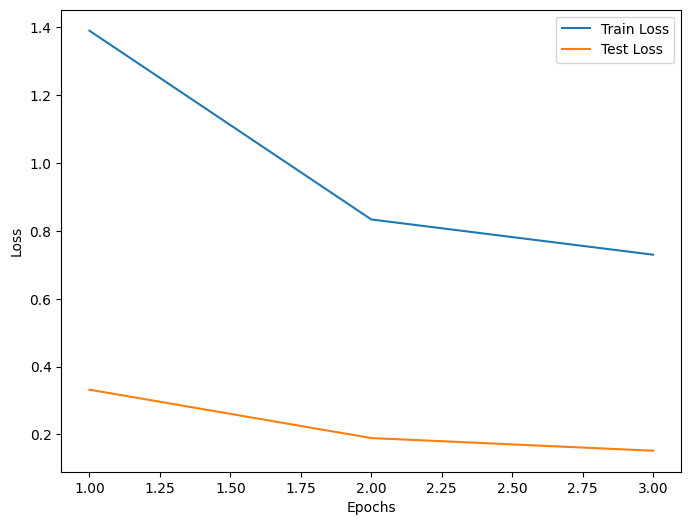

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_history["train"]) + 1), loss_history["train"], label="Train Loss")
plt.plot(range(1, len(loss_history["test"]) + 1), loss_history["test"], label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Можно заметить, что разница между Train Loss и Test Loss небольшая,а это значит, что переобучения нет. 

**Теперь проверим предсказания обученной модели.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

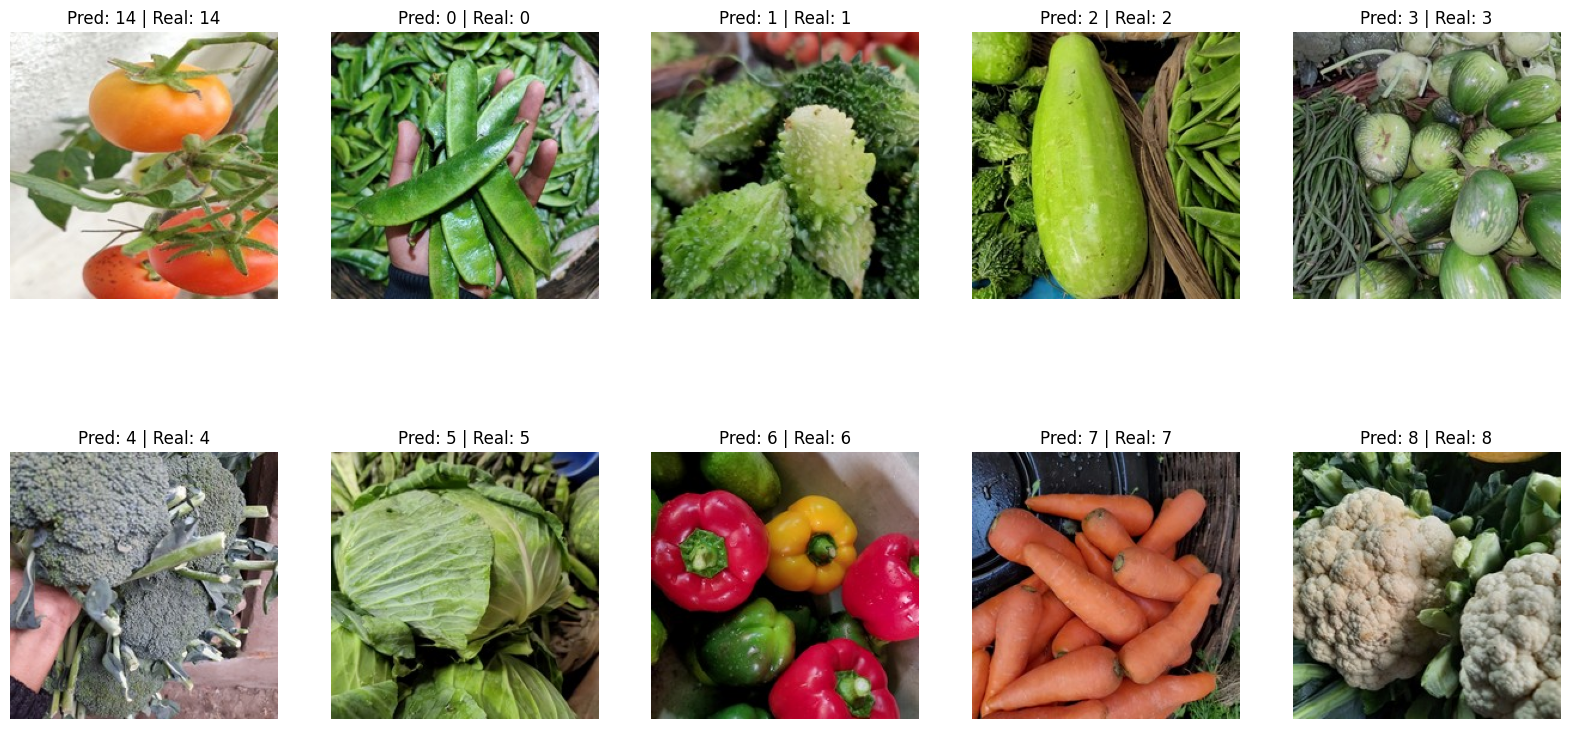

In [41]:
import random

# Собираем изображения из разных классов
selected_images = []
selected_labels = []
selected_preds = []

while len(selected_images) < 10:
    imgs, labels = next(test_generator)
    pred = model.predict(imgs)
    
    for i in range(len(imgs)):
        if np.argmax(labels[i]) not in selected_labels:
            selected_images.append(imgs[i])
            selected_labels.append(np.argmax(labels[i]))
            selected_preds.append(np.argmax(pred[i]))
        if len(selected_images) == 10:
            break

plt.figure(figsize=(20, 10))
for i in range(10):
    img = selected_images[i]
    plt.subplot(2, 5, i + 1)
    plt.title(f"Pred: {selected_preds[i]} | Real: {selected_labels[i]}")
    plt.axis("off")
    plt.imshow(img)
plt.show()


**4)Архитектура нейронной сети с нуля и ее обучение**

In [9]:
# Настройка использования GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for training")
else:
    print("No GPU found, training on CPU")

custom_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
epochs = 8
loss_history_custom = {"train": [], "test": []}

for epoch in trange(epochs, desc="Epochs"):
    history = custom_model.fit(train_generator, validation_data=val_generator, epochs=1, verbose=1)
    test_loss, test_accuracy = custom_model.evaluate(test_generator, verbose=1)
    loss_history_custom["train"].append(history.history['loss'][0])
    loss_history_custom["test"].append(test_loss)

print("Done!")

# Оценка модели
loss, accuracy = custom_model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Using GPU for training


Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 372ms/step - accuracy: 0.2918 - loss: 2.0710 - val_accuracy: 0.5537 - val_loss: 1.2501
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4960 - loss: 1.3669


Epochs:  12%|█▎        | 1/8 [03:05<21:40, 185.78s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 165s 347ms/step - accuracy: 0.5938 - loss: 1.1841 - val_accuracy: 0.7907 - val_loss: 0.6659
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7315 - loss: 0.7300


Epochs:  25%|██▌       | 2/8 [05:56<17:42, 177.16s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 164s 344ms/step - accuracy: 0.7219 - loss: 0.8161 - val_accuracy: 0.8687 - val_loss: 0.4198
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8146 - loss: 0.5040


Epochs:  38%|███▊      | 3/8 [08:47<14:30, 174.15s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 163s 343ms/step - accuracy: 0.7876 - loss: 0.6292 - val_accuracy: 0.8823 - val_loss: 0.3791
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8749 - loss: 0.3949


Epochs:  50%|█████     | 4/8 [11:37<11:30, 172.52s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 165s 347ms/step - accuracy: 0.8256 - loss: 0.5268 - val_accuracy: 0.9217 - val_loss: 0.2624
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9173 - loss: 0.2833


Epochs:  62%|██████▎   | 5/8 [14:29<08:36, 172.31s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 355ms/step - accuracy: 0.8549 - loss: 0.4435 - val_accuracy: 0.9150 - val_loss: 0.2604
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8997 - loss: 0.2955


Epochs:  75%|███████▌  | 6/8 [17:24<05:46, 173.40s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 166s 348ms/step - accuracy: 0.8788 - loss: 0.3749 - val_accuracy: 0.9460 - val_loss: 0.1819
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9608 - loss: 0.1770


Epochs:  88%|████████▊ | 7/8 [20:16<02:52, 172.94s/it]

469/469 ━━━━━━━━━━━━━━━━━━━━ 165s 346ms/step - accuracy: 0.8888 - loss: 0.3515 - val_accuracy: 0.9517 - val_loss: 0.1612
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9512 - loss: 0.1600


Epochs: 100%|██████████| 8/8 [23:07<00:00, 173.46s/it]

Done!


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9512 - loss: 0.1600
Test Accuracy: 95.37%


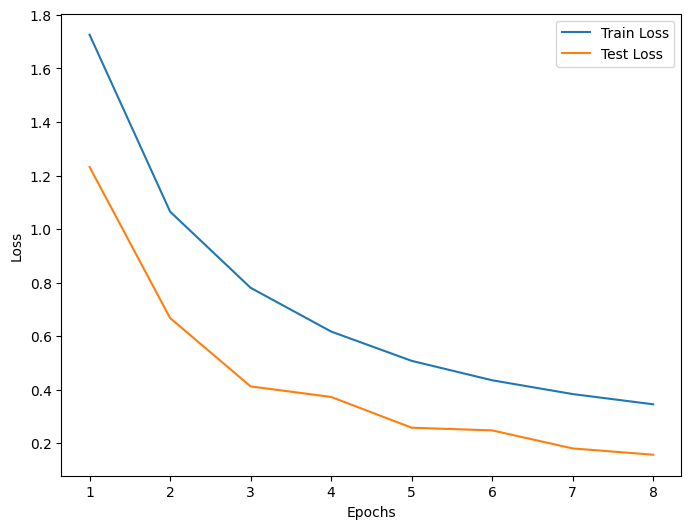

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_history_custom["train"]) + 1), loss_history_custom["train"], label="Train Loss")
plt.plot(range(1, len(loss_history_custom["test"]) + 1), loss_history_custom["test"], label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Проверим предсказания обученной модели.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

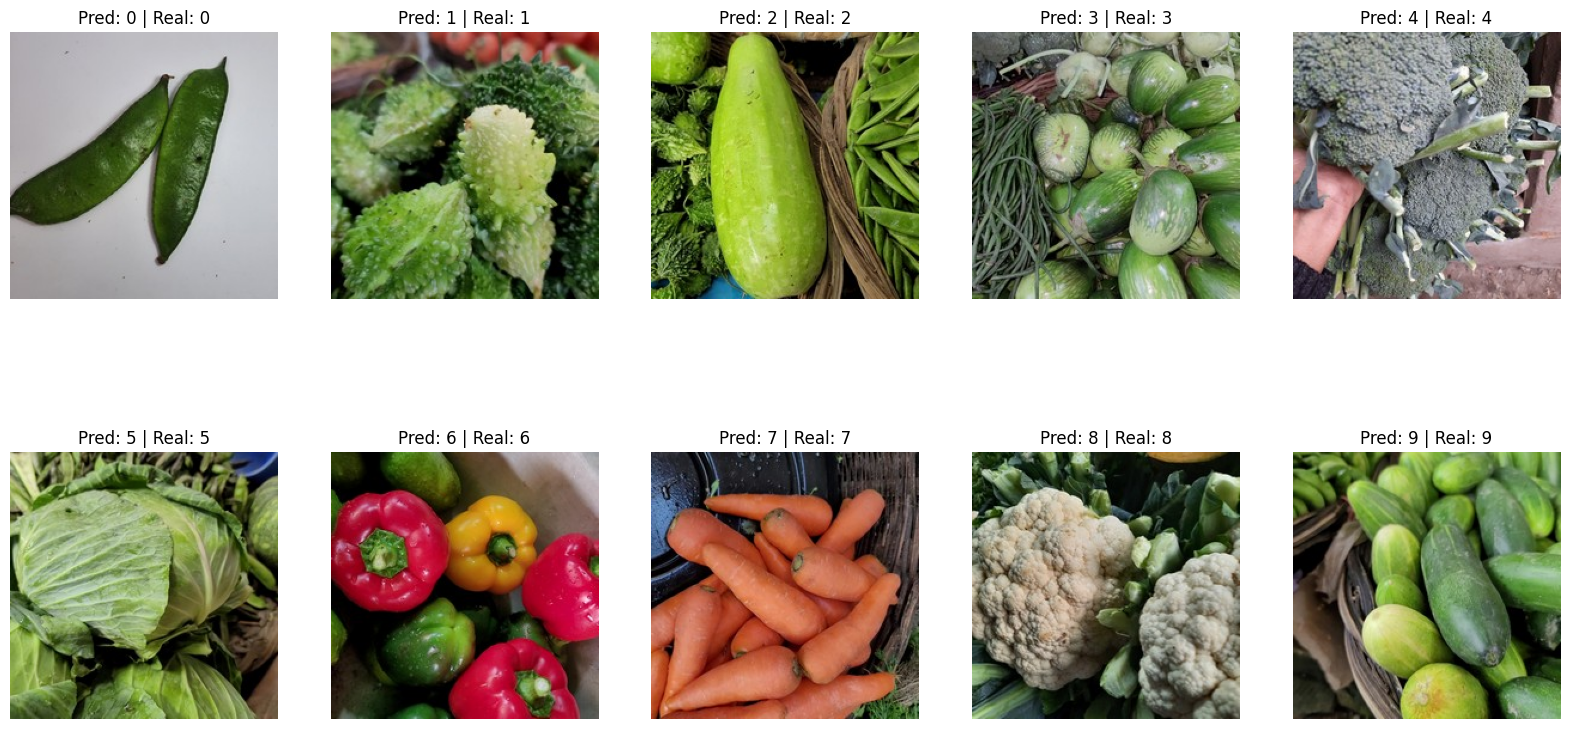

In [13]:
import random

# Собираем изображения из разных классов
selected_images = []
selected_labels = []
selected_preds = []

while len(selected_images) < 10:
    imgs, labels = next(test_generator)
    pred = custom_model.predict(imgs)
    
    for i in range(len(imgs)):
        if np.argmax(labels[i]) not in selected_labels:
            selected_images.append(imgs[i])
            selected_labels.append(np.argmax(labels[i]))
            selected_preds.append(np.argmax(pred[i]))
        if len(selected_images) == 10:
            break

plt.figure(figsize=(20, 10))
for i in range(10):
    img = selected_images[i]
    plt.subplot(2, 5, i + 1)
    plt.title(f"Pred: {selected_preds[i]} | Real: {selected_labels[i]}")
    plt.axis("off")
    plt.imshow(img)
plt.show()